In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

## Generate Testing Data

In [ ]:
np.random.seed(42)
n_samples = int( 10e2 )
df = pd.DataFrame({
    'x1': 5 + np.random.randn(n_samples) * 2,
    'x2': 10 + np.random.randn(n_samples) * 2,
    'x3': np.random.choice([0, 1, 2], size=n_samples, p=[0.25, 0.25, 0.5])
})

df['x3'] = df['x3'].astype('category')

df['y'] = 2 * np.cos(df['x1']) + 3 * np.sin(df['x2']) +\
    np.random.randn(n_samples) * 1 + \
        np.random.normal(loc = df['x3'].cat.codes, scale=0.5) + 10

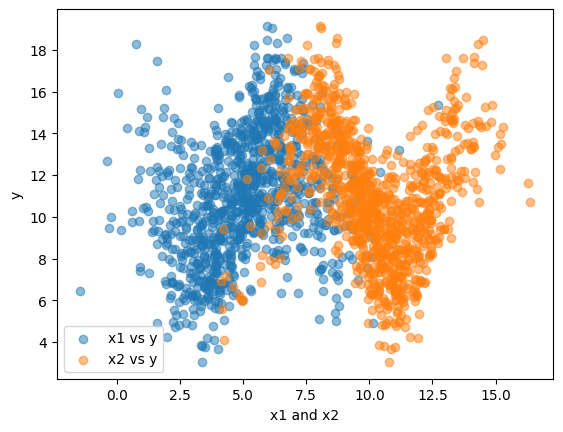

In [165]:
plt.scatter(df['x1'], df['y'], alpha=0.5, label='x1 vs y')
plt.scatter(df['x2'], df['y'], alpha=0.5, label='x2 vs y')
plt.xlabel('x1 and x2')
plt.ylabel('y')
plt.legend()

## Naive Linear Model

In [166]:
model = smf.ols('y ~ x1 + x2 + C(x3)', data=df).fit()

In [167]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     55.36
Date:                Mon, 04 Aug 2025   Prob (F-statistic):           3.53e-42
Time:                        23:00:19   Log-Likelihood:                -2410.2
No. Observations:                1000   AIC:                             4830.
Df Residuals:                     995   BIC:                             4855.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.4051      0.518     20.075      0.000       9.388      11.422
C(x3)[T.1]     1.3040      0.243      5.374      0.000       0.828       1.780
C(x3)[T.2]     2.1147      0.208     10.171      0.000       1.707       2.523
x1             0.3739      0.044      8.545      0.000       0.288       0.460
x2            -0.2657      0.043     -6.192      0.000      -0.350      -0.182
==============================================================================
Omnibus:                        9.005   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                7.311
Skew:                           0.125   Prob(JB):                       0.0259
Kurtosis:                       2.663   Cond. No.                         71.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

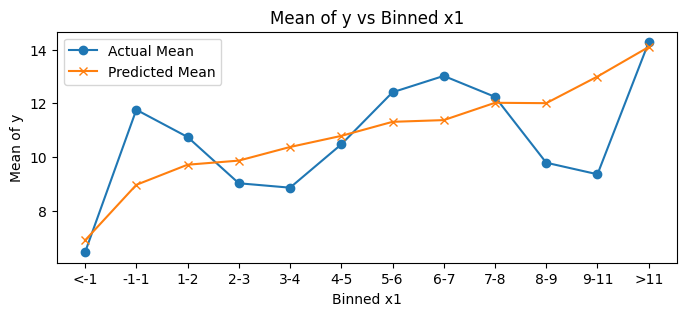

In [168]:
from quantbullet.dfutils import get_bins_and_labels

bins, labels = get_bins_and_labels( cutoffs=[-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11])
df['x1_binned'] = pd.cut(df['x1'], bins=bins, labels=labels)
df['ols_predicted'] = model.predict(df)

summary = df.groupby('x1_binned', observed=True).agg({'y': 'mean', 'ols_predicted': 'mean'})
plt.figure(figsize=(8, 3))
plt.plot(summary.index, summary['y'], marker='o', label='Actual Mean')
plt.plot(summary.index, summary['ols_predicted'], marker='x', label='Predicted Mean')
plt.xlabel('Binned x1')
plt.ylabel('Mean of y')
plt.title('Mean of y vs Binned x1')
plt.legend()

In [169]:
0.5 * np.sum ( np.power( df['ols_predicted'] - df['y'], 2 ) )

np.float64(3630.6766906164266)

## Multiplicative Model

In [142]:
from quantbullet.preprocessing.transformers import FlatRampTransformer
from numpy.linalg import lstsq

In [143]:
x1_trans = FlatRampTransformer(
    knots = [-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11],
    include_bias=True
)

x2_trans = FlatRampTransformer(
    knots = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    include_bias=True
)

In [144]:
train_df = np.concatenate([
    x1_trans.fit_transform(df['x1']),
    x2_trans.fit_transform(df['x2']),
], axis=1)

train_df = pd.DataFrame(train_df, columns = x1_trans.get_feature_names_out().tolist() + x2_trans.get_feature_names_out().tolist())

In [145]:
0.5 * np.sum( np.power( df['y'] -df['y'].mean() , 2 ) )

np.float64(4438.6632988829715)

In [146]:
v =  train_df.values @ ( np.ones( train_df.shape[1] ) * 0.1 )
0.5 * np.sum( np.power( v - df['y'], 2 ) )

np.float64(30670.50337641291)

In [147]:
solving_params, *_ = lstsq(train_df.values, df['y'], rcond=None)

In [148]:
df['ols_piecewise_predicted'] = train_df.values @ solving_params
0.5 * np.sum( np.power( df['ols_piecewise_predicted'] - df['y'], 2 ) )

np.float64(981.4495140128788)

In [149]:

feature_sets = {'x1': x1_trans.get_feature_names_out().tolist(), 'x2': x2_trans.get_feature_names_out().tolist() }
initial_params = { feature_set : np.zeros( len( feature_names ) ) for feature_set, feature_names in feature_sets.items() }
num_iterations = 10

In [150]:
solving_params_x1, *_ = lstsq(train_df[ feature_sets['x1'] ].values, df['y'], rcond=None)
df['ols_x1_predicted'] = train_df[ feature_sets['x1'] ].values @ solving_params_x1
solving_params_x2, *_ = lstsq(train_df[ feature_sets['x2'] ].values, df['y'], rcond=None)
df['ols_x2_predicted'] = train_df[ feature_sets['x2'] ].values @ solving_params_x2

0.5 * np.sum( np.power( df['ols_x1_predicted'] - df['y'], 2 ) )
0.5 * np.sum( np.power( df['ols_x2_predicted'] - df['y'], 2 ) )

np.float64(1973.728915846762)

In [151]:

feature_sets = {'x1': x1_trans.get_feature_names_out().tolist(), 'x2': x2_trans.get_feature_names_out().tolist() }
initial_params = { feature_set : np.zeros( len( feature_names ) ) for feature_set, feature_names in feature_sets.items() }
num_iterations = 10

for i in range(num_iterations):
    for solving_set in feature_sets:
        print(f"Solving for feature set: {solving_set}")

        solving_y = df['y'].values.copy()

        # subtract other contributions
        for fixed_set in feature_sets:
            if fixed_set == solving_set:
                continue
            inner = train_df[feature_sets[fixed_set]].values @ initial_params[fixed_set]
            inner = np.clip(inner, 1e-1, None)
            solving_y -= np.log(inner)

        # linearize
        solving_x = train_df[feature_sets[solving_set]].values
        solving_y = np.exp(solving_y)

        # stable OLS
        solving_params, *_ = lstsq(solving_x, solving_y, rcond=None)
        initial_params[solving_set] = solving_params

        print(f"Updated parameters for {solving_set}: {initial_params[solving_set]}")

    # compute model predictions with all params
    y_hat = np.zeros(len(df))
    for fs in feature_sets:
        inner = train_df[feature_sets[fs]].values @ initial_params[fs]
        inner = np.clip(inner, 1e-8, None)
        y_hat += np.log(inner)

    cost = 0.5 * np.sum((y_hat - df['y'].values) ** 2)
    print(f"Iteration {i+1}, Cost: {cost}")


Solving for feature set: x1
Updated parameters for x1: [-1.89819505e+07  4.00788277e+07  1.84416115e+07 -5.31733195e+07
 -4.01009876e+06  5.68579714e+06 -1.00393443e+07  1.02304105e+08
 -5.96467014e+07 -3.20700300e+07 -5.48108755e+06  1.16625227e+06
  2.59403696e+07]
Solving for feature set: x2
Updated parameters for x2: [ 7415048.84321338   204184.96623066  -624753.21478852  2384837.34752028
 -1085745.15452504   -54796.69227086  -798597.00914937    51410.0619806
   183025.52055477  -148509.63100522  3941752.60321455 -3398877.04817125
  -576695.57812775]
Iteration 1, Cost: 154062.63632363357
Solving for feature set: x1
Updated parameters for x1: [ 2893392.09014039   -16779.88842784    10599.47949888   -20416.43356796
    26413.44286557   -50915.75272287   263225.51072764  -795207.35211603
  3724724.22212237 -3108118.62130547   -53468.36770131     6555.02634337
    -7905.55584444]
Solving for feature set: x2
Updated parameters for x2: [ 1.45674149e+08 -3.43746563e+06  1.19371269e+07 -8.

## Optimize globally with `least_squares`

### Without Jacobian

In [171]:
import numpy as np

def model(params, X_blocks):
    """
    params: concatenated parameter vector for all blocks
    X_blocks: list of (X, n_features)
    """
    n = X_blocks[0][0].shape[0]
    y_hat = np.zeros(n)
    idx = 0
    for X, n_feat in X_blocks:
        theta = params[idx: idx+n_feat]
        idx += n_feat
        inner = X @ theta
        # enforce positivity inside log
        inner = np.clip(inner, 1e-8, None)
        y_hat += np.log(inner)
    return y_hat

def residuals(params, X_blocks, y):
    y_hat = model(params, X_blocks)
    return y_hat - y

from scipy.optimize import least_squares

# Example: two blocks x1, x2
X1 = train_df[feature_sets['x1']].values
X2 = train_df[feature_sets['x2']].values

X_blocks = [(X1, X1.shape[1]), (X2, X2.shape[1])]
y = df['y'].values

# initial guess (all 1’s)
init_params = np.ones(sum(n for _, n in X_blocks))

res = least_squares(
    residuals,
    init_params,
    args=(X_blocks, y),
    method="trf",        # trust region reflective
    loss="linear",       # can try "huber" if outliers
    verbose=1,
    ftol=1e-6
)

print("Success:", res.success)
print("Optimal params:", res.x)


`ftol` termination condition is satisfied.
Function evaluations 89, initial cost 6.5563e+03, final cost 9.9175e+02, first-order optimality 4.77e-01.
Success: True
Optimal params: [ 4.03306040e+02  6.42216175e+03 -9.47508792e+02 -1.18326494e+03
 -4.08499672e+01  5.96832857e+01  7.99585733e+02  4.47704790e+03
 -1.93523380e+03 -3.14804051e+03 -2.65021124e+02  3.35804780e+01
  1.75086999e+03  3.72197182e+03  3.32807137e-01  2.98793453e+01
  3.88411797e+02  1.69916163e+03 -1.93596102e+03 -1.71360730e+02
 -9.30085114e+00  9.53778669e+00  1.53683170e+02  2.76364235e+03
 -2.29734853e+03 -4.45630368e+02]


In [172]:
0.5 * np.sum((model(res.x, X_blocks) - y) ** 2)

np.float64(991.753239253436)

### With Jacobian

In [173]:
import numpy as np
from scipy.optimize import least_squares

def model_and_jacobian(params, X_blocks):
    """
    params: concatenated parameter vector for all blocks
    X_blocks: list of (X, n_features)
    Returns:
        y_hat: (n_samples,)
        J: (n_samples, n_params)
    """
    n = X_blocks[0][0].shape[0]
    y_hat = np.zeros(n)
    J = np.zeros((n, len(params)))
    
    idx = 0
    for X, n_feat in X_blocks:
        theta = params[idx: idx+n_feat]
        inner = X @ theta
        inner = np.clip(inner, 1e-12, None)  # enforce positivity
        
        # add to model
        y_hat += np.log(inner)
        
        # Jacobian for this block
        # derivative wrt each parameter in this block = X[:, j] / inner
        J[:, idx: idx+n_feat] = X / inner[:, None]
        
        idx += n_feat
    
    return y_hat, J

def residuals(params, X_blocks, y):
    y_hat, _ = model_and_jacobian(params, X_blocks)
    return y_hat - y

def jacobian(params, X_blocks, y):
    _, J = model_and_jacobian(params, X_blocks)
    return J

# ---------------- Example ----------------
X1 = train_df[feature_sets['x1']].values
X2 = train_df[feature_sets['x2']].values

X_blocks = [(X1, X1.shape[1]), (X2, X2.shape[1])]
y = df['y'].values

# initial guess
init_params = np.ones(sum(n for _, n in X_blocks))

res = least_squares(
    residuals,
    init_params,
    jac=jacobian,       # <-- use analytic Jacobian
    args=(X_blocks, y),
    method="trf",       # trust region reflective
    loss="linear",      # try "huber" for outliers
    verbose=1,
    ftol=1e-6,
    xtol=1e-6,  # tolerance for parameter convergence
)

print("Success:", res.success)
print("Optimal params:", res.x)


`ftol` termination condition is satisfied.
Function evaluations 80, initial cost 6.5563e+03, final cost 9.9167e+02, first-order optimality 9.87e-02.
Success: True
Optimal params: [ 3.99171134e+03  5.72541261e+03 -9.44404494e+02 -8.56672146e+02
 -3.04686693e+01  4.42338694e+01  5.91044197e+02  3.31487979e+03
 -1.43562905e+03 -2.32728300e+03 -1.96337495e+02  2.56950986e+01
  1.06640633e+03  5.12295091e+03  4.50050134e-01  4.03643287e+01
  5.25696082e+02  2.29816067e+03 -2.61913975e+03 -2.31410810e+02
 -1.25361371e+01  1.27840211e+01  2.07810486e+02  3.80154147e+03
 -3.17884992e+03 -5.96830641e+02]


In [174]:
0.5 * np.sum ( np.power( df['non_linear_pred'] - df['y'], 2 ) )

np.float64(991.6740733693903)

In [175]:
df['non_linear_pred'] = model(res.x, X_blocks)

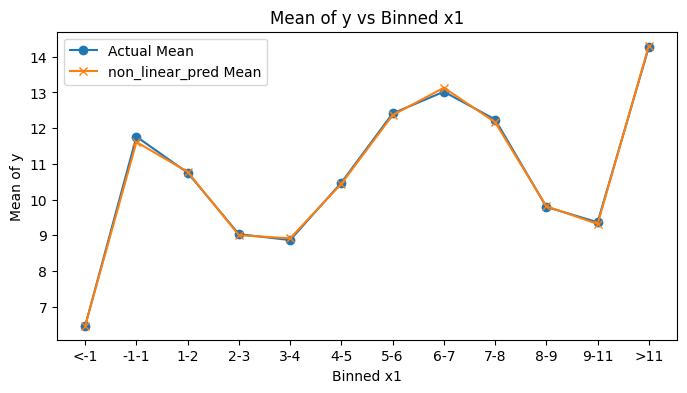

In [176]:
from quantbullet.dfutils import get_bins_and_labels

summary = df.groupby('x1_binned', observed=True).agg({'y': 'mean', 'non_linear_pred': 'mean'})
plt.figure(figsize=(8, 4))
plt.plot(summary.index, summary['y'], marker='o', label='Actual Mean')
plt.plot(summary.index, summary['non_linear_pred'], marker='x', label='non_linear_pred Mean')
plt.xlabel('Binned x1')
plt.ylabel('Mean of y')
plt.title('Mean of y vs Binned x1')
plt.legend()

In [177]:
res.x

array([ 3.99171134e+03,  5.72541261e+03, -9.44404494e+02, -8.56672146e+02,
       -3.04686693e+01,  4.42338694e+01,  5.91044197e+02,  3.31487979e+03,
       -1.43562905e+03, -2.32728300e+03, -1.96337495e+02,  2.56950986e+01,
        1.06640633e+03,  5.12295091e+03,  4.50050134e-01,  4.03643287e+01,
        5.25696082e+02,  2.29816067e+03, -2.61913975e+03, -2.31410810e+02,
       -1.25361371e+01,  1.27840211e+01,  2.07810486e+02,  3.80154147e+03,
       -3.17884992e+03, -5.96830641e+02])

## Using Pytorch

In [159]:
import torch
import torch.nn as nn
import torch.optim as optim

# Convert data to torch tensors
X_blocks = []
for fs in feature_sets:
    X = torch.tensor(train_df[feature_sets[fs]].values, dtype=torch.float32)
    X_blocks.append(X)

y = torch.tensor(df['y'].values, dtype=torch.float32)

# Define model parameters (one tensor per block)
params = []
for fs in feature_sets:
    n_features = len(feature_sets[fs])
    theta = nn.Parameter(torch.ones(n_features))
    params.append(theta)

# Put parameters into an optimizer
optimizer = optim.LBFGS(params, lr=1e-4, max_iter=100)  # or Adam for large data

# Forward function
def forward():
    y_hat = torch.zeros_like(y)
    for X, theta in zip(X_blocks, params):
        inner = X @ theta
        inner = torch.clamp(inner, min=1e-8)   # avoid log domain errors
        y_hat += torch.log(inner)
    return y_hat

# Loss function = MSE
loss_fn = nn.MSELoss()


ModuleNotFoundError: No module named 'torch'

In [ ]:
def closure():
    optimizer.zero_grad()
    y_hat = forward()
    loss = loss_fn(y_hat, y)
    loss.backward()
    return loss

# for epoch in range(500):
#     loss = optimizer.step(closure)
#     print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")

best_loss = float("inf")
best_params = None

for epoch in range(500):
    loss = optimizer.step(closure)   # LBFGS step calls closure internally
    print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")

    # track best so far
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_params = [p.detach().clone() for p in params]

Epoch 1, Loss: 13.106525
Epoch 2, Loss: 13.061668
Epoch 3, Loss: 13.016368
Epoch 4, Loss: 12.970942
Epoch 5, Loss: 12.925093
Epoch 6, Loss: 12.878268
Epoch 7, Loss: 12.830283
Epoch 8, Loss: 12.782050
Epoch 9, Loss: 12.733860
Epoch 10, Loss: 12.685713
Epoch 11, Loss: 12.637607
Epoch 12, Loss: 12.589520
Epoch 13, Loss: 12.541466
Epoch 14, Loss: 12.493422
Epoch 15, Loss: 12.445391
Epoch 16, Loss: 12.397363
Epoch 17, Loss: 12.349337
Epoch 18, Loss: 12.301304
Epoch 19, Loss: 12.253270
Epoch 20, Loss: 12.205230
Epoch 21, Loss: 12.157170
Epoch 22, Loss: 12.109107
Epoch 23, Loss: 12.061027
Epoch 24, Loss: 12.012938
Epoch 25, Loss: 11.964850
Epoch 26, Loss: 11.916739
Epoch 27, Loss: 11.868635
Epoch 28, Loss: 11.820527
Epoch 29, Loss: 11.772413
Epoch 30, Loss: 11.724299
Epoch 31, Loss: 11.676203
Epoch 32, Loss: 11.628107
Epoch 33, Loss: 11.580025
Epoch 34, Loss: 11.531951
Epoch 35, Loss: 11.483898
Epoch 36, Loss: 11.435869
Epoch 37, Loss: 11.387841
Epoch 38, Loss: 11.339833
Epoch 39, Loss: 11.29

In [ ]:
all_params = torch.cat([p.detach() for p in best_params]).cpu().numpy()
print("All params:", all_params)

All params: [   58.00649       4.5559897  -529.7939     -990.55054    -101.89295
    30.058332    519.22375    2006.2145     -582.56793   -1806.7689
  -206.81737      51.966328    721.1335     -103.60025     -34.97933
   116.4769     1555.7231      912.8703    -2267.0725     -292.85703
   -19.204224     28.790558    647.43024     890.47614    -856.6517
  -182.11406  ]


In [ ]:
X1 = train_df[feature_sets['x1']].values
X2 = train_df[feature_sets['x2']].values

X_blocks = [(X1, X1.shape[1]), (X2, X2.shape[1])]

In [ ]:
df['torch_linear_pred'] = model(all_params, X_blocks)

In [ ]:
from quantbullet.dfutils import get_bins_and_labels

summary = df.groupby('x1_binned', observed=True).agg({'y': 'mean', 'torch_linear_pred': 'mean'})
plt.figure(figsize=(8, 3))
plt.plot(summary.index, summary['y'], marker='o', label='Actual Mean')
plt.plot(summary.index, summary['torch_linear_pred'], marker='x', label='torch_linear_pred Mean')
plt.xlabel('Binned x1')
plt.ylabel('Mean of y')
plt.title('Mean of y vs Binned x1')
plt.legend()

KeyError: "Column(s) ['torch_linear_pred'] do not exist"